# ***Cardiac MRI Segmentation using UNet***
#### *Author: Rituraj Dutta*
#### *Email: riturajdutta400@gmail.com*

In [1]:
!nvidia-smi

Mon Aug  9 05:19:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torch==1.7.0 torchvision==0.8.0
!pip install medicaltorch

     |████████████████████████████████| 776.7 MB 4.2 kB/s 
     |████████████████████████████████| 11.8 MB 65.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.0 which is incompatible.


In [3]:
!unzip /content/drive/MyDrive/Task02_Heart.zip

Archive:  /content/drive/MyDrive/Task02_Heart.zip
   creating: Task02_Heart/
  inflating: Task02_Heart/._dataset.json  
  inflating: Task02_Heart/._imagesTr  
  inflating: Task02_Heart/._imagesTs  
  inflating: Task02_Heart/._labelsTr  
   creating: Task02_Heart/imagesTr/
  inflating: Task02_Heart/imagesTr/la_007.nii.gz  
  inflating: Task02_Heart/imagesTr/la_019.nii.gz  
  inflating: Task02_Heart/imagesTr/la_023.nii.gz  
  inflating: Task02_Heart/imagesTr/la_005.nii.gz  
  inflating: Task02_Heart/imagesTr/la_009.nii.gz  
  inflating: Task02_Heart/imagesTr/la_017.nii.gz  
  inflating: Task02_Heart/imagesTr/la_021.nii.gz  
  inflating: Task02_Heart/imagesTr/._la_029.nii.gz  
  inflating: Task02_Heart/imagesTr/la_029.nii.gz  
  inflating: Task02_Heart/imagesTr/la_003.nii.gz  
  inflating: Task02_Heart/imagesTr/la_011.nii.gz  
  inflating: Task02_Heart/imagesTr/la_030.nii.gz  
  inflating: Task02_Heart/imagesTr/la_022.nii.gz  
  inflating: Task02_Heart/imagesTr/la_014.nii.gz  
  inflating

(320, 320)
(320, 320)


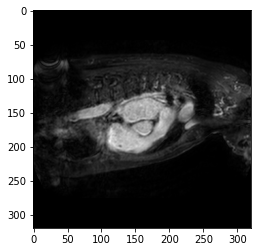

In [4]:
from collections import defaultdict
import time
import os

import numpy as np

from tqdm import tqdm

#from tensorboardX import SummaryWriter

from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import matplotlib.pyplot as plt

cudnn.benchmark = True


ROOT_DIR_GMCHALLENGE = "/content/Task02_Heart"
mri_input_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                          'imagesTr/la_004.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                       'labelsTr/la_004.nii.gz')


pair = mt_datasets.SegmentationPair2D(mri_input_filename,mri_gt_filename)

slice_pair = pair.get_pair_slice(55)   ## Slice Number

input_slice = slice_pair["input"]
print(input_slice.shape)
gt_slice = slice_pair["gt"]
print(gt_slice.shape)

img = input_slice
plt.imshow(img,cmap='gray')
plt.show()

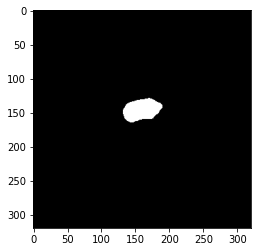

In [5]:

img = gt_slice
plt.imshow(img,cmap='gray')
plt.show()

In [6]:
img_data,seg_data = pair.get_pair_data()
print(img_data.shape)
print(seg_data.shape)

(320, 320, 110)
(320, 320, 110)


In [7]:
img_list = os.listdir(os.path.join(ROOT_DIR_GMCHALLENGE,'imagesTr'))
label_list = os.listdir(os.path.join(ROOT_DIR_GMCHALLENGE,'labelsTr'))

In [8]:
filename_pairs = [(os.path.join(ROOT_DIR_GMCHALLENGE,'imagesTr',x),os.path.join(ROOT_DIR_GMCHALLENGE,'labelsTr',y)) for x,y in zip(img_list,label_list)]

In [9]:
len(filename_pairs)
filename_pairs

[('/content/Task02_Heart/imagesTr/la_024.nii.gz',
  '/content/Task02_Heart/labelsTr/la_024.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_026.nii.gz',
  '/content/Task02_Heart/labelsTr/la_026.nii.gz'),
 ('/content/Task02_Heart/imagesTr/._la_029.nii.gz',
  '/content/Task02_Heart/labelsTr/._la_029.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_010.nii.gz',
  '/content/Task02_Heart/labelsTr/._la_014.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_005.nii.gz',
  '/content/Task02_Heart/labelsTr/la_010.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_022.nii.gz',
  '/content/Task02_Heart/labelsTr/la_005.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_011.nii.gz',
  '/content/Task02_Heart/labelsTr/la_022.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_009.nii.gz',
  '/content/Task02_Heart/labelsTr/la_011.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_020.nii.gz',
  '/content/Task02_Heart/labelsTr/la_009.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_016.nii.gz',
  '/content/Task02_Heart/labelsTr/l

In [10]:
filename_pairs_train = [
                  ('/content/Task02_Heart/imagesTr/la_003.nii.gz','/content/Task02_Heart/labelsTr/la_003.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_004.nii.gz','/content/Task02_Heart/labelsTr/la_004.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_005.nii.gz','/content/Task02_Heart/labelsTr/la_005.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_007.nii.gz','/content/Task02_Heart/labelsTr/la_007.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_009.nii.gz','/content/Task02_Heart/labelsTr/la_009.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_010.nii.gz','/content/Task02_Heart/labelsTr/la_010.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_011.nii.gz','/content/Task02_Heart/labelsTr/la_011.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_014.nii.gz','/content/Task02_Heart/labelsTr/la_014.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_016.nii.gz','/content/Task02_Heart/labelsTr/la_016.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_017.nii.gz','/content/Task02_Heart/labelsTr/la_017.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_018.nii.gz','/content/Task02_Heart/labelsTr/la_018.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_019.nii.gz','/content/Task02_Heart/labelsTr/la_019.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_020.nii.gz','/content/Task02_Heart/labelsTr/la_020.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_021.nii.gz','/content/Task02_Heart/labelsTr/la_021.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_022.nii.gz','/content/Task02_Heart/labelsTr/la_022.nii.gz')
                 
]

In [11]:
filename_pairs_train

[('/content/Task02_Heart/imagesTr/la_003.nii.gz',
  '/content/Task02_Heart/labelsTr/la_003.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_004.nii.gz',
  '/content/Task02_Heart/labelsTr/la_004.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_005.nii.gz',
  '/content/Task02_Heart/labelsTr/la_005.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_007.nii.gz',
  '/content/Task02_Heart/labelsTr/la_007.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_009.nii.gz',
  '/content/Task02_Heart/labelsTr/la_009.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_010.nii.gz',
  '/content/Task02_Heart/labelsTr/la_010.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_011.nii.gz',
  '/content/Task02_Heart/labelsTr/la_011.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_014.nii.gz',
  '/content/Task02_Heart/labelsTr/la_014.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_016.nii.gz',
  '/content/Task02_Heart/labelsTr/la_016.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_017.nii.gz',
  '/content/Task02_Heart/labelsTr/la_017.

In [12]:
filename_pairs_val = [
                  ('/content/Task02_Heart/imagesTr/la_023.nii.gz','/content/Task02_Heart/labelsTr/la_023.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_024.nii.gz','/content/Task02_Heart/labelsTr/la_024.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_026.nii.gz','/content/Task02_Heart/labelsTr/la_026.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_029.nii.gz','/content/Task02_Heart/labelsTr/la_029.nii.gz'),
                  ('/content/Task02_Heart/imagesTr/la_030.nii.gz','/content/Task02_Heart/labelsTr/la_030.nii.gz')
                  
]

In [13]:
filename_pairs_val

[('/content/Task02_Heart/imagesTr/la_023.nii.gz',
  '/content/Task02_Heart/labelsTr/la_023.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_024.nii.gz',
  '/content/Task02_Heart/labelsTr/la_024.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_026.nii.gz',
  '/content/Task02_Heart/labelsTr/la_026.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_029.nii.gz',
  '/content/Task02_Heart/labelsTr/la_029.nii.gz'),
 ('/content/Task02_Heart/imagesTr/la_030.nii.gz',
  '/content/Task02_Heart/labelsTr/la_030.nii.gz')]

In [14]:
train_transform = transforms.Compose([
        #mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((256, 256)),

        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])
val_transform = transforms.Compose([
        #mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((256, 256)),

        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

In [15]:
train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs_train,transform=train_transform)
val_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs_val,transform=val_transform)


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=16,
                        shuffle=True, num_workers=1,
                        collate_fn=mt_datasets.mt_collate)

val_dataloader = DataLoader(val_dataset, batch_size=16,
                        shuffle=True, num_workers=1,
                        collate_fn=mt_datasets.mt_collate)


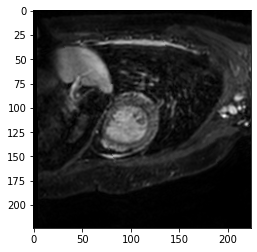

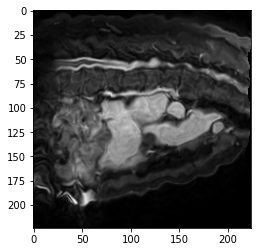

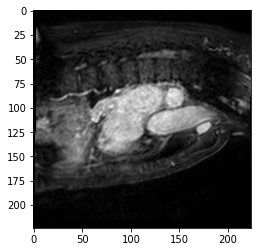

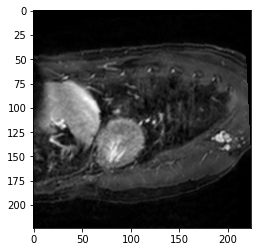

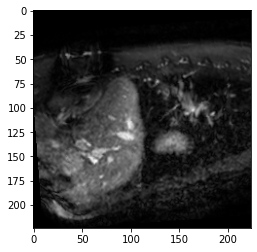

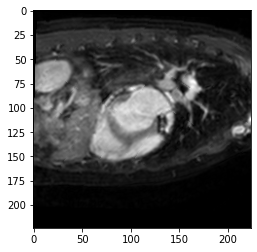

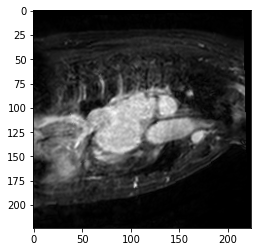

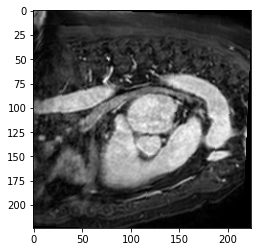

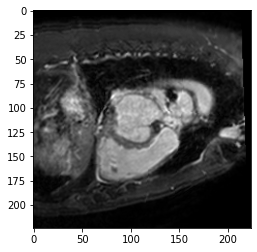

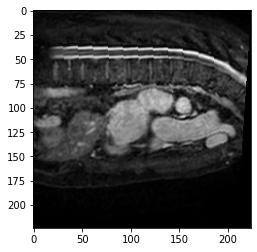

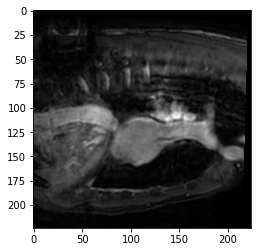

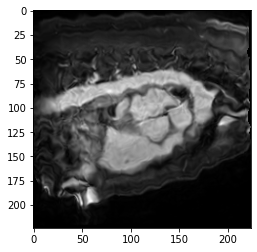

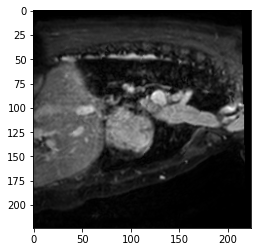

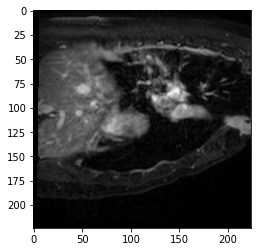

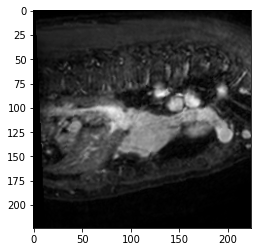

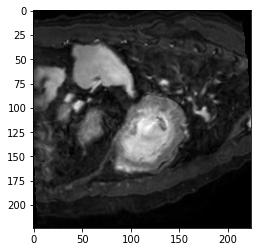

In [ ]:
batch = next(iter(train_dataloader))

for item in batch['input']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

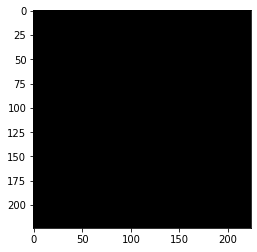

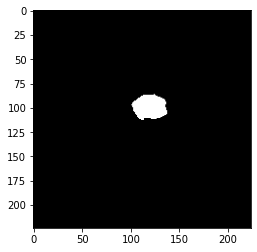

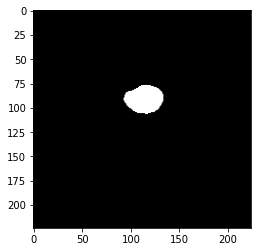

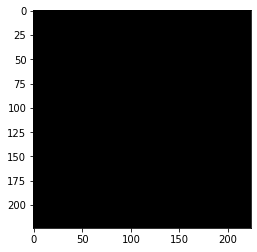

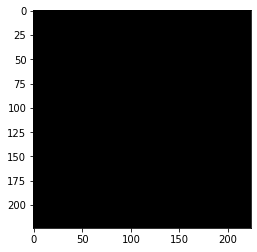

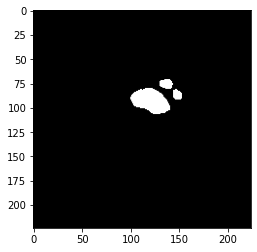

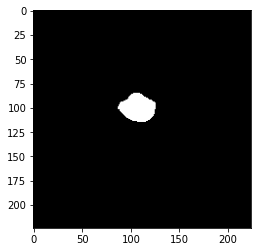

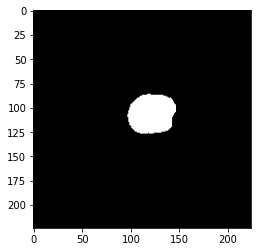

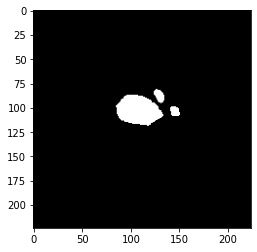

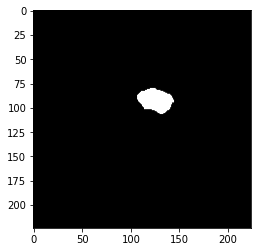

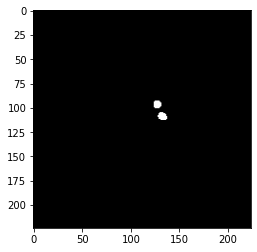

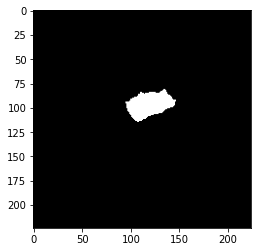

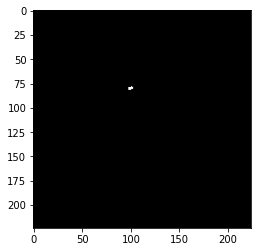

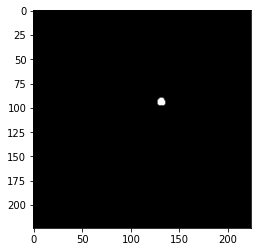

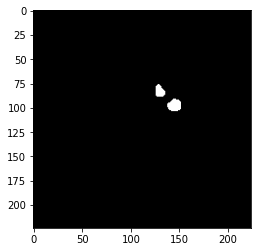

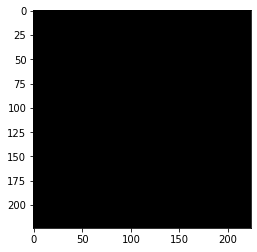

In [ ]:
for item in batch['gt']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

In [17]:
def threshold_predictions(predictions, thr=0.999):
    thresholded_preds = predictions[:]
    low_values_indices = thresholded_preds < thr
    thresholded_preds[low_values_indices] = 0
    low_values_indices = thresholded_preds >= thr
    thresholded_preds[low_values_indices] = 1
    return thresholded_preds

In [18]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [19]:
class DownConv(nn.Module):
    def __init__(self, in_feat, out_feat, drop_rate=0.4, bn_momentum=0.1):
        super(DownConv, self).__init__()
        self.conv1 = nn.Conv2d(in_feat, out_feat, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_feat, momentum=bn_momentum)
        self.conv1_drop = nn.Dropout2d(drop_rate)

        self.conv2 = nn.Conv2d(out_feat, out_feat, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(out_feat, momentum=bn_momentum)
        self.conv2_drop = nn.Dropout2d(drop_rate)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(x)
        x = self.conv1_drop(x)

        x = F.relu(self.conv2(x))
        x = self.conv2_bn(x)
        x = self.conv2_drop(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_feat, out_feat, drop_rate=0.4, bn_momentum=0.1):
        super(UpConv, self).__init__()
        self.up1 = nn.functional.interpolate
        self.downconv = DownConv(in_feat, out_feat, drop_rate, bn_momentum)

    def forward(self, x, y):
        x = self.up1(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, y], dim=1)
        x = self.downconv(x)
        return x

In [20]:
class Unet(nn.Module):
    """A reference U-Net model.

    .. seealso::
        Ronneberger, O., et al (2015). U-Net: Convolutional
        Networks for Biomedical Image Segmentation
        ArXiv link: https://arxiv.org/abs/1505.04597
    """
    def __init__(self, drop_rate=0.4, bn_momentum=0.1):
        super(Unet, self).__init__()

        #Downsampling path
        self.conv1 = DownConv(1, 64, drop_rate, bn_momentum)
        self.mp1 = nn.MaxPool2d(2)

        self.conv2 = DownConv(64, 128, drop_rate, bn_momentum)
        self.mp2 = nn.MaxPool2d(2)

        self.conv3 = DownConv(128, 256, drop_rate, bn_momentum)
        self.mp3 = nn.MaxPool2d(2)

        # Bottom
        self.conv4 = DownConv(256, 256, drop_rate, bn_momentum)

        # Upsampling path
        self.up1 = UpConv(512, 256, drop_rate, bn_momentum)
        self.up2 = UpConv(384, 128, drop_rate, bn_momentum)
        self.up3 = UpConv(192, 64, drop_rate, bn_momentum)

        self.conv9 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.mp1(x1)

        x3 = self.conv2(x2)
        x4 = self.mp2(x3)

        x5 = self.conv3(x4)
        x6 = self.mp3(x5)

        # Bottom
        x7 = self.conv4(x6)

        # Up-sampling
        x8 = self.up1(x7, x5)
        x9 = self.up2(x8, x3)
        x10 = self.up3(x9, x1)

        x11 = self.conv9(x10)
        preds = torch.sigmoid(x11)

        return preds

In [21]:
model = Unet(drop_rate=0.0)
model.cuda()
num_epochs = 30
initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
early_stopping = EarlyStopping(patience=5,verbose=True)

In [22]:
def numeric_score(prediction, groundtruth):
    FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
    FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
    TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
    TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))
    return FP, FN, TP, TN 
  
def accuracy(prediction, groundtruth):
    FP, FN, TP, TN = numeric_score(prediction, groundtruth)
    N = FP + FN + TP + TN
    accuracy = np.divide(TP + TN, N)
    return accuracy * 100.0

In [23]:
def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)

In [24]:
train_loss = []
val_loss = []
train_Acc = []
val_Acc = []


for epoch in tqdm(range(1, num_epochs+1)):
    start_time = time.time()

    scheduler.step()

    lr = scheduler.get_lr()[0]

    model.train()
    train_loss_total = 0.0
    num_steps = 0
    
    ### Training
    

    for i, batch in enumerate(train_dataloader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        var_input = input_samples.cuda()
        var_gt = gt_samples.cuda()

        preds = model(var_input)

        loss = dice_loss(preds, var_gt)
        train_loss_total += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1

        if epoch % 5 == 0:
            
            grid_img1 = vutils.make_grid(input_samples,
                                        normalize=True,
                                        scale_each=True,
                                        pad_value=100)
            img = input_samples
            

            grid_img2 = vutils.make_grid(preds.data.cpu(),
                                        normalize=True,
                                        scale_each=True,
                                        pad_value=100)
            predictions = preds.data.cpu()

            grid_img3 = vutils.make_grid(gt_samples,
                                        normalize=True,
                                        scale_each=True,
                                        pad_value=100)
            
            mask = gt_samples
   
    
    train_loss_total_avg = train_loss_total / num_steps
    train_loss.append(train_loss_total_avg)
    model.eval()
    val_loss_total = 0.0
    num_steps = 0
    train_acc  = accuracy(preds.cpu().detach().numpy(), 
                          var_gt.cpu().detach().numpy())

    train_Acc.append(train_acc)
    

            
    ### Validating
    for i, batch in enumerate(val_dataloader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        with torch.no_grad():
            var_input = input_samples.cuda()
            var_gt = gt_samples.cuda()

            preds = model(var_input)
            loss = dice_loss(preds, var_gt)
            val_loss_total += loss.item()

            val_acc  = accuracy(preds.cpu().detach().numpy(), 
                              var_gt.cpu().detach().numpy())
            
            val_Acc.append(val_acc)

        num_steps += 1
        
   
    val_loss_total_avg = val_loss_total / num_steps
    val_loss.append(val_loss_total_avg)

    early_stopping(val_loss_total_avg, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
   
    print('\nTrain loss: {:.4f}, Training Accuracy: {:.4f} '.format(train_loss_total_avg, train_acc))
    print('Val Loss: {:.4f}, Validation Accuracy: {:.4f} '.format(val_loss_total_avg, val_acc))

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means

Validation loss decreased (inf --> 0.717337).  Saving model ...

Train loss: 0.8454, Training Accuracy: 20.9532 
Val Loss: 0.7173, Validation Accuracy: 30.0227 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

Validation loss decreased (0.717337 --> 0.620459).  Saving model ...

Train loss: 0.4324, Training Accuracy: 72.3971 
Val Loss: 0.6205, Validation Accuracy: 56.0823 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

Validation loss decreased (0.620459 --> 0.229628).  Saving model ...

Train loss: 0.3901, Training Accuracy: 47.9475 
Val Loss: 0.2296, Validation Accuracy: 88.9844 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 1 out of 5

Train loss: 0.2130, Training Accuracy: 89.7552 
Val Loss: 0.3882, Validation Accuracy: 99.8681 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

Validation loss decreased (0.229628 --> 0.114764).  Saving model ...

Train loss: 0.1752, Training Accuracy: 88.2324 
Val Loss: 0.1148, Validation Accuracy: 97.1532 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 1 out of 5

Train loss: 0.1494, Training Accuracy: 94.5802 
Val Loss: 0.1355, Validation Accuracy: 94.4552 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 2 out of 5

Train loss: 0.1345, Training Accuracy: 94.5892 
Val Loss: 0.1241, Validation Accuracy: 96.7130 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 3 out of 5

Train loss: 0.1292, Training Accuracy: 96.0425 
Val Loss: 0.1871, Validation Accuracy: 68.3598 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

Validation loss decreased (0.114764 --> 0.101663).  Saving model ...

Train loss: 0.1315, Training Accuracy: 90.8494 
Val Loss: 0.1017, Validation Accuracy: 96.6844 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 1 out of 5

Train loss: 0.1246, Training Accuracy: 88.0269 
Val Loss: 0.1293, Validation Accuracy: 99.8180 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 2 out of 5

Train loss: 0.1145, Training Accuracy: 93.0726 
Val Loss: 0.1106, Validation Accuracy: 94.4272 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

Validation loss decreased (0.101663 --> 0.097371).  Saving model ...

Train loss: 0.1162, Training Accuracy: 97.8441 
Val Loss: 0.0974, Validation Accuracy: 94.7339 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

Validation loss decreased (0.097371 --> 0.095033).  Saving model ...

Train loss: 0.1058, Training Accuracy: 97.8873 
Val Loss: 0.0950, Validation Accuracy: 95.4401 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

Validation loss decreased (0.095033 --> 0.086837).  Saving model ...

Train loss: 0.0990, Training Accuracy: 88.9741 
Val Loss: 0.0868, Validation Accuracy: 97.6116 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 1 out of 5

Train loss: 0.0974, Training Accuracy: 92.5723 
Val Loss: 0.0966, Validation Accuracy: 90.3826 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 2 out of 5

Train loss: 0.0958, Training Accuracy: 97.5249 
Val Loss: 0.1004, Validation Accuracy: 91.5592 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 3 out of 5

Train loss: 0.0931, Training Accuracy: 95.0953 
Val Loss: 0.0893, Validation Accuracy: 96.8818 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 4 out of 5

Train loss: 0.0914, Training Accuracy: 88.7854 
Val Loss: 0.1014, Validation Accuracy: 87.1337 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

EarlyStopping counter: 5 out of 5
Early stopping


In [79]:
def show(img):
    npimg = img.numpy()

    for i in range(6):
  
        # Debug, plot figure
        imgs = np.transpose(npimg[i], (1,2,0))
        im = imgs[:,:,0]
        

        plt.imshow(im,cmap='gray')
        plt.savefig('foo.png', bbox_inches='tight')
        plt.show()
      

    
  

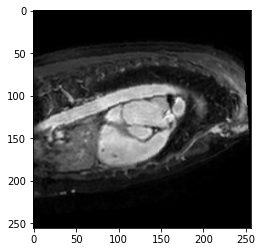

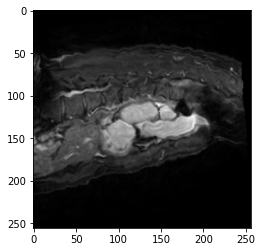

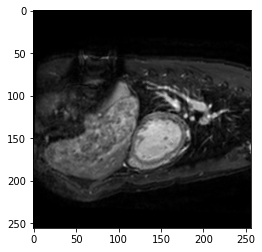

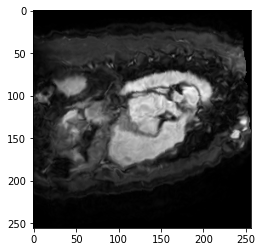

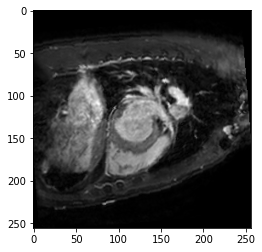

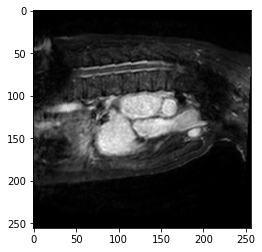

In [80]:
show(img)  ## Input Image

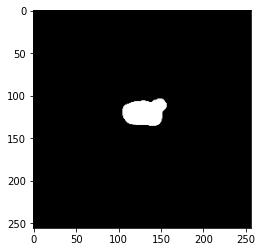

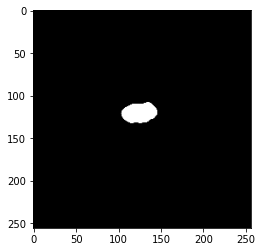

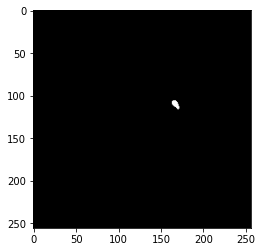

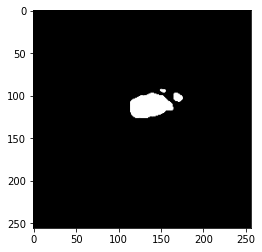

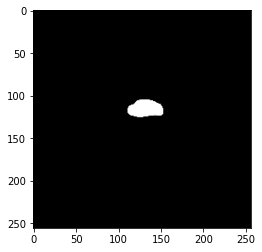

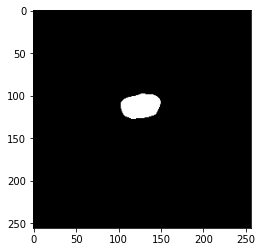

In [81]:
show(predictions)  ## Predictions

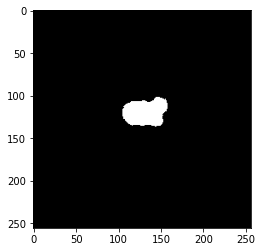

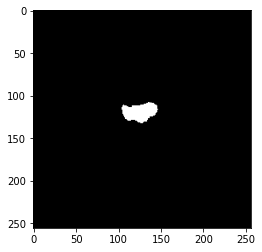

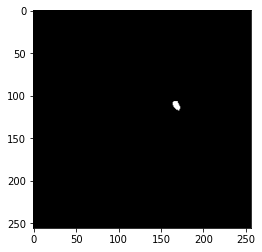

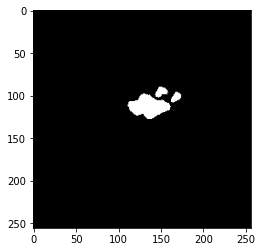

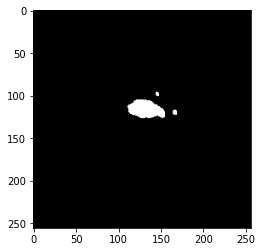

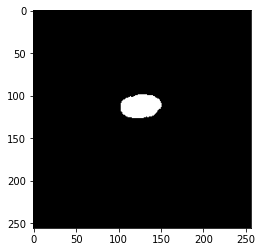

In [82]:
show(mask)   ## Ground Truth